#  פרוייקט גמר
####  יובל בר-און
####  ענבל אקרמן
####  איתן לכצייר 
---
    
1. [טעינת ספריות](#section1)
2. [סידור הדאטה - המרה למספרים עם LabelEncoder](#section2)
3. [קורלציות בין המשתנים המספריים לבין עמודת החיזוי](#section3)
4. [קורלציה בין כל המשתנים](#section4)
5. [בחירת עמודות והסבר](#section5)
6. [Feature Engineering - יצירת פרופיל פסיכולוגי](#section6)
7. [חיזוי](#section7)
8. [דוגמה - "מחשבון יין"](#section8)


<a id='section1'></a>
### 1. טעינת ספריות ונתונים

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, f1_score, matthews_corrcoef, cohen_kappa_score
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("wine.csv")
df = data.copy()
df.head()

,גיל,מין,מחוז נוכחי,מחוז בילדות,מצב כלכלי,מצב משפחתי,קרבה לדת,מספר אחים,מספר אימונים בשבוע,סוג דיאטה,מספר בילויים בחודש,מעשנ.ת,התנסות בסמים,הורים גרושים,לימודים,רישיון נהיגה,משיכה מינית,קעקועים,משקה יין מועדף
0,29,זכר,צפון,צפון,גבוה,רווק,חילוני,1,3,ללא גלוטן,10,לא,כן,כן,אקדמאי,כן,סטרייט,לא,קאווה
1,51,זכר,מרכז,צפון,גבוה,רווק,חילוני,1,5,ללא,3,כן,לא,לא,אקדמאי,לא,סטרייט,לא,שרדונה
2,32,זכר,יהודה ושומרון,יהודה ושומרון,גבוה,רווק,חילוני,1,5,ללא,7,לא,לא,כן,12 שנות לימוד,כן,סטרייט,כן,ריוחה
3,36,נקבה,דרום,מרכז,גבוה,רווק,מסורתי,3,3,ללא,6,כן,לא,לא,אקדמאי,לא,סטרייט,לא,גוורץ
4,44,נקבה,דרום,מרכז,גבוה,נשוי,מסורתי,2,6,ללא,1,כן,לא,כן,12 שנות לימוד,לא,סטרייט,לא,קברנה סוביניון


In [3]:
#df.isnull().sum()

In [3]:
#
df = df.rename(columns={
    'גיל': 'age',
    'מין': 'gender',
    'מחוז נוכחי': 'current_district',
    'מחוז בילדות': 'childhood_district',
    'מצב כלכלי': 'economic_status',
    'מצב משפחתי': 'marital_status',
    'קרבה לדת': 'religiosity',
    'מספר אחים': 'num_siblings',
    'מספר אימונים בשבוע': 'weekly_workouts',
    'סוג דיאטה': 'diet_type',
    'מספר בילויים בחודש': 'monthly_outings',
    'מעשנ.ת': 'smoking',
    'התנסות בסמים': 'drug_experience',
    'הורים גרושים': 'divorced_parents',
    'לימודים': 'education',
    'רישיון נהיגה': 'driving_license',
    'משיכה מינית': 'sexual_orientation',
    'קעקועים': 'tattoos',
    'משקה יין מועדף': 'preferred_wine'
})

#df.head()

הורדת העמודות של המחוז - לפי היכרות עם הלקוחות הקבועים + אנשים המומחים ביין, הבנו שרוב הסקר שלנו בנוי על אנשים מהמרכז, שגדלו גם במרכז. לכן נוריד אותם.

In [4]:
df = df.drop(['current_district', 'childhood_district'], axis=1)

<a id='section2'></a>
### 2. LabelEncoder (לצורך קורלציות)

In [5]:
df_for_correlations = df.copy()

# זיהוי סוגי העמודות
numeric_columns = []
categorical_columns = []
label_encoders = {}

for column in df.columns:
    if column == 'preferred_wine':
        continue 
    elif df[column].dtype in ['int64', 'float64']:
        numeric_columns.append(column)
        
    else:
        categorical_columns.append(column)
      
        
        # המרה ב-LabelEncoder לצורך קורלציות
        from sklearn.preprocessing import LabelEncoder
        le = LabelEncoder()
        df_for_correlations[column] = le.fit_transform(df[column])
        label_encoders[column] = le


# המרת יין מועדף למספרים
wine_mapping = {
    'גוורץ': 0,
    'קאווה': 1,
    'קברנה סוביניון': 2,
    'ריוחה': 3,
    'שרדונה': 4
}
df_for_correlations['wine_code'] = df['preferred_wine'].map(wine_mapping)


# מחיקת העמודה המקורית של היין (השארת רק הקוד)
df_for_correlations = df_for_correlations.drop(['preferred_wine'], axis=1)

df_for_correlations.head()

,age,gender,economic_status,marital_status,religiosity,num_siblings,weekly_workouts,diet_type,monthly_outings,smoking,drug_experience,divorced_parents,education,driving_license,sexual_orientation,tattoos,wine_code
0,29,0,1,2,1,1,3,2,10,1,0,0,1,0,2,1,1
1,51,0,1,2,1,1,5,1,3,0,1,1,1,1,2,1,4
2,32,0,1,2,1,1,5,1,7,1,1,0,0,0,2,0,3
3,36,1,1,2,2,3,3,1,6,0,1,1,1,1,2,1,0
4,44,1,1,1,2,2,6,1,1,0,1,0,0,1,2,1,2


<a id='section3'></a>
### 3. קורלציות בין המשתנים המספריים לבין עמודת החיזוי - היין

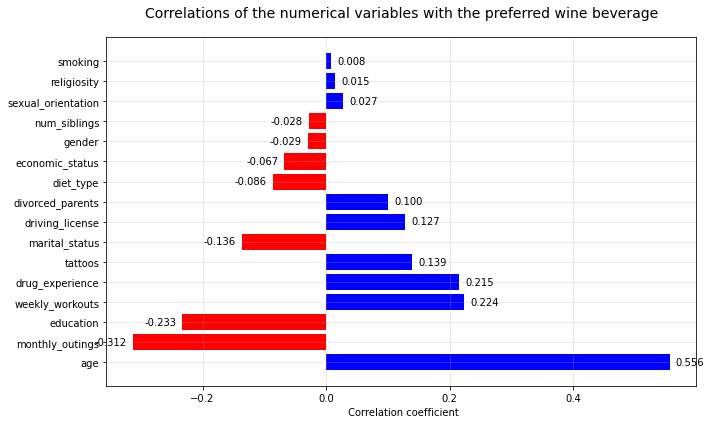

קורלציות עם יין מועדף (מסודר לפי חוזק):
  age: 0.556 (חזקה, חיובית)
  monthly_outings: -0.312 (בינונית, שלילית)
  education: -0.233 (חלשה, שלילית)
  weekly_workouts: 0.224 (חלשה, חיובית)
  drug_experience: 0.215 (חלשה, חיובית)
  tattoos: 0.139 (חלשה, חיובית)
  marital_status: -0.136 (חלשה, שלילית)
  driving_license: 0.127 (חלשה, חיובית)
  divorced_parents: 0.100 (חלשה, חיובית)
  diet_type: -0.086 (חלשה, שלילית)
  economic_status: -0.067 (חלשה, שלילית)
  gender: -0.029 (חלשה, שלילית)
  num_siblings: -0.028 (חלשה, שלילית)
  sexual_orientation: 0.027 (חלשה, חיובית)
  religiosity: 0.015 (חלשה, חיובית)
  smoking: 0.008 (חלשה, חיובית)

3 המשתנים המספריים הכי משפיעים על בחירת היין:
  age: 0.556
  monthly_outings: -0.312
  education: -0.233


In [6]:
correlation_matrix = df_for_correlations.corr()

if 'wine_code' in correlation_matrix.columns:
    target_correlations = correlation_matrix['wine_code'].drop('wine_code').sort_values(key=abs, ascending=False)

    # גרף קורלציות עם המשתנה התלוי
    plt.figure(figsize=(10, 6))
    colors = ['red' if x < 0 else 'blue' for x in target_correlations]
    bars = plt.barh(range(len(target_correlations)), target_correlations.values, color=colors)
    plt.yticks(range(len(target_correlations)), target_correlations.index)
    plt.title('Correlations of the numerical variables with the preferred wine beverage', fontsize=14, pad=20)
    plt.xlabel(' Correlation coefficient')
    plt.grid(True, alpha=0.3)
    
    # הוספת ערכים על הברים
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + (0.01 if width > 0 else -0.01), bar.get_y() + bar.get_height()/2, 
                f'{width:.3f}', ha='left' if width > 0 else 'right', va='center')
    
    plt.tight_layout()
    plt.show()

    print("קורלציות עם יין מועדף (מסודר לפי חוזק):")
    for feature, corr in target_correlations.items():
        strength = "חזקה" if abs(corr) > 0.5 else "בינונית" if abs(corr) > 0.3 else "חלשה"
        direction = "חיובית" if corr > 0 else "שלילית"
        print(f"  {feature}: {corr:.3f} ({strength}, {direction})")

    # זיהוי המשתנים הכי משפיעים
    if len(target_correlations) >= 3:
        most_influential = target_correlations.head(3)
        print(f"\n3 המשתנים המספריים הכי משפיעים על בחירת היין:")
        for feature, corr in most_influential.items():
            print(f"  {feature}: {corr:.3f}")

<a id='section4'></a>
### 4. קורלציה בין כל המשתנים (כולל קטגוריאליים מקודדים)

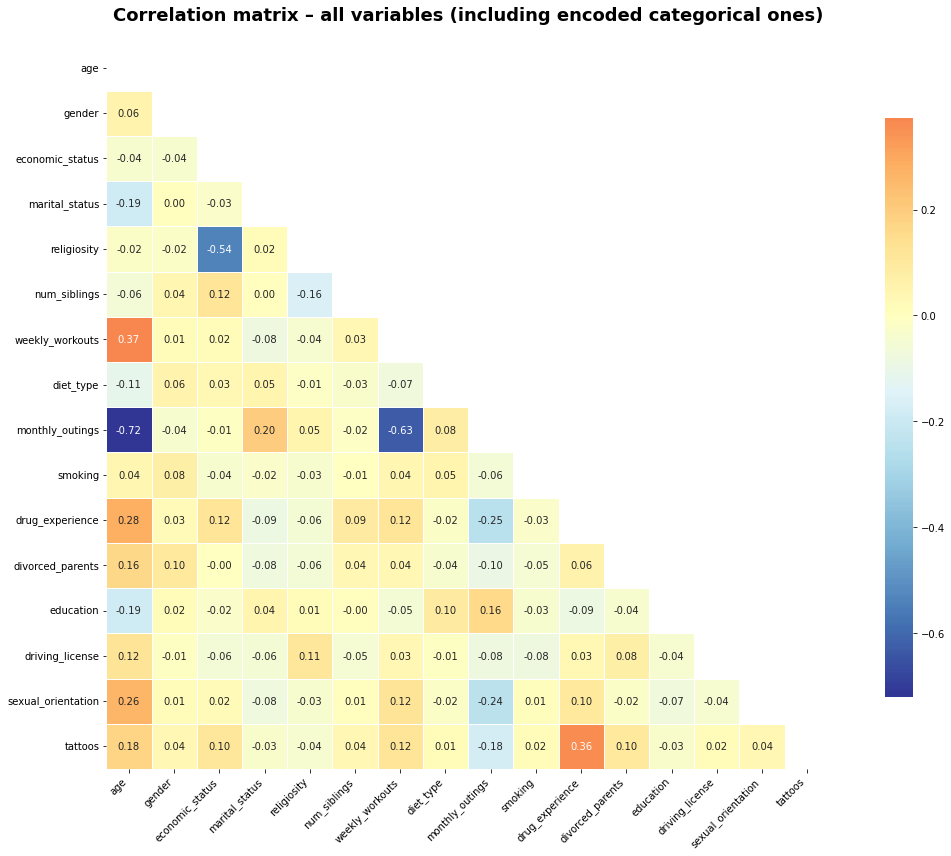


 ניתוח קורלציות חזקות:

 קורלציות חזקות מאוד (מעל 0.7):
  age ↔ monthly_outings: -0.720 (שלילית)

 קורלציות בינוניות (0.4-0.7) - מציג את 5 החזקות:
  weekly_workouts ↔ monthly_outings: -0.635 (שלילית)
  economic_status ↔ religiosity: -0.537 (שלילית)


In [7]:
correlation_matrix = df_for_correlations.drop(columns=['wine_code']).corr()


# יצירת גרף קורלציות 
plt.figure(figsize=(16, 12))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# יצירת heatmap עם עיצוב יפה
sns.heatmap(correlation_matrix, 
            mask=mask,
            annot=True, 
            cmap='RdYlBu_r',  # צבעים יפים יותר
            center=0,
            square=True,
            fmt='.2f',
            cbar_kws={"shrink": .8},
            linewidths=0.5)

plt.title('Correlation matrix – all variables (including encoded categorical ones)', 
          fontsize=18, pad=25, weight='bold')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
#plt.savefig('correlation_matrix.png', dpi=300) # מייצאת לי את התמונה החוצה
plt.show()




# ניתוח קורלציות חזקות
print("\n ניתוח קורלציות חזקות:")
high_corr = []
medium_corr = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        var1 = correlation_matrix.columns[i]
        var2 = correlation_matrix.columns[j]
        
        if abs(corr_val) > 0.7:
            high_corr.append((var1, var2, corr_val))
        elif abs(corr_val) > 0.4:
            medium_corr.append((var1, var2, corr_val))

# הדפסת קורלציות חזקות
if high_corr:
    print("\n קורלציות חזקות מאוד (מעל 0.7):")
    for var1, var2, corr in sorted(high_corr, key=lambda x: abs(x[2]), reverse=True):
        direction = "חיובית" if corr > 0 else "שלילית"
        print(f"  {var1} ↔ {var2}: {corr:.3f} ({direction})")
else:
    print("\n אין קורלציות חזקות מאוד (מעל 0.7)")

# הדפסת קורלציות בינוניות
if medium_corr:
    print(f"\n קורלציות בינוניות (0.4-0.7) - מציג את 5 החזקות:")
    sorted_medium = sorted(medium_corr, key=lambda x: abs(x[2]), reverse=True)[:5]
    for var1, var2, corr in sorted_medium:
        direction = "חיובית" if corr > 0 else "שלילית"
        print(f"  {var1} ↔ {var2}: {corr:.3f} ({direction})")


<a id='section5'></a>
### 5. בחירת עמודות לחיזוי (ולאפלקיציה עצמה) והסבר

הסרת העמודות "מספר אחים" ו"סוג דיאטה" - שתי העמודות לא הראו קורלציות חזקות עם שאר המשתנים, ובנוסף צוות המסעדה העריך שהן פחות קריטיות בשלב זה

הסרת העמודה "מצב כלכלי" – נמצאה קורלציה נמוכה בינה לבין עמודת היין, לצד קורלציה גבוהה עם עמודת "קרבה לדת". לכן, הוחלט להשאיר את "קרבה לדת" שתייצג גם את עצמה וגם את המצב הכלכלי.

הסרת העמודה "מספר אימונים בשבוע" – נמצאה קורלציה נמוכה עם עמודת היין, אך קורלציה גבוהה (שלילית) עם עמודת "מספר בילויים בחודש". לכן, הוחלט להשאיר את "מספר בילויים בחודש" שתייצג גם את עצמה וגם את מספר האימונים בשבוע.

הסרת העמודות: "נסיון בסמים", "הורים גרושים", "קעקועים" - פרטים אישיים שאנשים יכולים להרגיש לא בנוח לתת אותם. כמו כן אולי פסחו עליהם בסקר.

In [9]:
df = df.drop(['diet_type', 'num_siblings','economic_status','weekly_workouts','drug_experience', 'divorced_parents','tattoos'], axis=1)
#df.head()

,age,gender,marital_status,religiosity,monthly_outings,smoking,education,driving_license,sexual_orientation,preferred_wine
0,29,זכר,רווק,חילוני,10,לא,אקדמאי,כן,סטרייט,קאווה
1,51,זכר,רווק,חילוני,3,כן,אקדמאי,לא,סטרייט,שרדונה
2,32,זכר,רווק,חילוני,7,לא,12 שנות לימוד,כן,סטרייט,ריוחה
3,36,נקבה,רווק,מסורתי,6,כן,אקדמאי,לא,סטרייט,גוורץ
4,44,נקבה,נשוי,מסורתי,1,כן,12 שנות לימוד,לא,סטרייט,קברנה סוביניון


<a id='section6'></a>
### 6. Feature Engineering - יצירת פרופיל פסיכולוגי

הבטחנו לעצמנו שהאפליקציה תהיה פשוטה ונוחה לשימוש, כך שהלקוחות לא יצטרכו למלא פרטים מיותרים. חשבנו כיצד לשלב מספר עמודות למשתנה אחד שיסכם מידע משמעותי. לאחר מחקר על קבוצות פסיכולוגיות, החלטנו ליצור עמודת "פרופיל פסיכולוגי" המורכבת מהעמודות "משיכה מינית", "רישיון נהיגה", "לימודים" ו"מצב משפחתי". ארבעת העמודות האלו מעניקות לנו תובנות חשובות לגבי הפרופיל הפסיכולוגי של המשתמשים. כמובן, מדובר בהכללות ובהנחות מוקדמות, אך הן מסייעות לנו בשיפור תהליך למידת המכונה.

מאמר נוסף התומך בקבלת ההחלטה :

https://www.researchgate.net/publication/374163425_An_Academic_Review_About_Human_Psychology_Demographics_Features

In [10]:
# פונקציה ליצירת פרופיל פסיכולוגי
def create_psychological_profile(marital_status, education, has_license, sexual_orientation):
    traditionalism_score = 0
    innovation_score = 0
    
    # מצב משפחתי
    if marital_status in ["נשוי", "אלמן"]:
        traditionalism_score += 2
    elif marital_status == "גרוש":
        traditionalism_score += 1
        innovation_score += 1
    elif marital_status == "רווק":
        innovation_score += 2
    
    # השכלה
    if education == "אקדמאי":
        traditionalism_score += 1
        innovation_score += 1
    elif education == "12 שנות לימוד":
        traditionalism_score += 2
    elif education == "פחות מ12 שנות לימוד":
        traditionalism_score += 1
    
    # רישיון נהיגה
    if has_license == "כן":
        traditionalism_score += 1
    else:
        innovation_score += 1
    
    # נטייה מינית
    if sexual_orientation == "סטרייט":
        traditionalism_score += 2
    elif sexual_orientation == "גיי":
        innovation_score += 1
    elif sexual_orientation == "בי":
        innovation_score += 2
    
    ratio = traditionalism_score / (innovation_score + 0.01)
    
    if ratio >= 2.5:
        return "שמרני מובהק"
    elif 1.5 <= ratio < 2.5:
        return "קונבנציונלי"
    elif 0.9 <= ratio < 1.5:
        return "מאוזן"
    elif 0.4 <= ratio < 0.9:
        return "חדשני"
    else:
        return "חופשי"

# יצירת פרופיל פסיכולוגי
print("יוצר פרופיל פסיכולוגי...")
df['psychological_profile'] = df.apply(
    lambda row: create_psychological_profile(
        row['marital_status'], 
        row['education'], 
        row['driving_license'], 
        row['sexual_orientation']
    ), axis=1
)

print("התפלגות פרופילים פסיכולוגיים:")
print(df['psychological_profile'].value_counts())

df = df.drop(['marital_status','sexual_orientation','driving_license','education'], axis=1)


יוצר פרופיל פסיכולוגי...
התפלגות פרופילים פסיכולוגיים:
psychological_profile
שמרני מובהק    249
קונבנציונלי    229
מאוזן          213
חדשני           90
חופשי           63
Name: count, dtype: int64


<a id='section7'></a>
### 7. חיזוי

התפלגות יינות בדאטה:
preferred_wine
קברנה סוביניון    187
שרדונה            174
קאווה             163
גוורץ             162
ריוחה             158
Name: count, dtype: int64

פיצ'רים סופיים לחיזוי: ['age', 'gender', 'religiosity', 'monthly_outings', 'smoking', 'psychological_profile']
צורת X: (844, 6)
התפלגות y: 
wine_code
0    162
1    163
2    187
3    158
4    174
Name: count, dtype: int64
גודלי סטים - Train: (442, 6), Validation: (148, 6), Test: (254, 6)

מאמן מודל...

תוצאות ראשוניות:
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.61      0.56        49
           1       0.87      0.80      0.83        49
           2       0.69      0.62      0.65        56
           3       0.65      0.65      0.65        48
           4       0.94      0.94      0.94        52

    accuracy                           0.72       254
   macro avg       0.73      0.72      0.73       254
weighted avg       0.73      0.72      0.73       

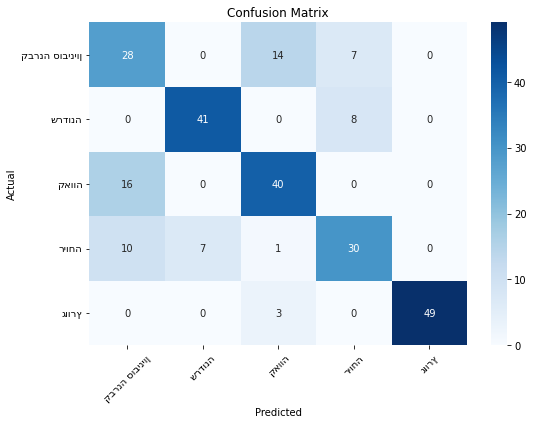

In [11]:
# סינון ליינות הרלוונטיים בלבד
relevant_wines = ['קברנה סוביניון', 'שרדונה', 'קאווה', 'ריוחה', 'גוורץ']
df = df[df['preferred_wine'].isin(relevant_wines)]

print(f"התפלגות יינות בדאטה:")
print(df['preferred_wine'].value_counts())

# המרת שמות היינות לקודים
wine_mapping = {
    'גוורץ': 0,
    'קאווה': 1,
    'קברנה סוביניון': 2,
    'ריוחה': 3,
    'שרדונה': 4
}
df['wine_code'] = df['preferred_wine'].map(wine_mapping)

# הגדרת X ו-y (6 הפיצ'רים הסופיים)
final_features = ['age', 'gender', 'religiosity', 'monthly_outings', 'smoking', 'psychological_profile']
X = df[final_features]
y = df['wine_code']

print(f"\nפיצ'רים סופיים לחיזוי: {final_features}")
print(f"צורת X: {X.shape}")
print(f"התפלגות y: \n{y.value_counts().sort_index()}")

# חלוקה לסטים
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

print(f"גודלי סטים - Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")

# טרנספורמציות
numeric_features = ['age', 'monthly_outings']
categorical_features = ['gender', 'religiosity', 'smoking', 'psychological_profile']
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# הגדרת המודל
xgb_classifier = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    objective='multi:softmax',
    num_class=5,
    eval_metric='mlogloss',
    random_state=42
)

# בניית הפייפליין
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb_classifier)
])

# אימון ראשוני
print("\nמאמן מודל...")
xgb_pipeline.fit(X_train, y_train)
y_pred = xgb_pipeline.predict(X_test)

# הערכה ראשונית
print("\nתוצאות ראשוניות:")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# אופטימיזציית פרמטרים
print("\nמריץ אופטימיזציה של פרמטרים...")
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [4, 6, 8],
    'classifier__learning_rate': [0.05, 0.1, 0.2]
}

grid_search = GridSearchCV(xgb_pipeline, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score (F1 Macro): {grid_search.best_score_:.4f}")

# מודל סופי
best_model = grid_search.best_estimator_
final_y_pred = best_model.predict(X_test)

# תוצאות סופיות
print("\n" + "="*50)
print("תוצאות סופיות")
print("="*50)

print("Final Classification Report:")
print(classification_report(y_test, final_y_pred))

final_accuracy = np.mean(y_test == final_y_pred)
final_macro_f1 = f1_score(y_test, final_y_pred, average='macro')
final_weighted_f1 = f1_score(y_test, final_y_pred, average='weighted')
final_mcc = matthews_corrcoef(y_test, final_y_pred)
final_kappa = cohen_kappa_score(y_test, final_y_pred)

print(f"\nFinal Metrics:")
print(f"Accuracy: {final_accuracy:.4f}")
print(f"Macro F1-Score: {final_macro_f1:.4f}")
print(f"Weighted F1-Score: {final_weighted_f1:.4f}")
print(f"Matthews Correlation Coefficient: {final_mcc:.4f}")
print(f"Cohen's Kappa: {final_kappa:.4f}")

# מטריצת בלבול
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, final_y_pred)
wine_names = ['קברנה סוביניון', 'שרדונה', 'קאווה', 'ריוחה', 'גוורץ']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=wine_names, yticklabels=wine_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


<a id='section8'></a>
### 8. מחשבון לדוגמה - הזנת הנתונים וחישוב יין מועדף לפי הלמידה

מוזמנים לנסות ב - לרשום את הפרטים שלכם ב result

In [12]:
# המרה חזרה לשמות
inverse_wine_mapping = {v: k for k, v in wine_mapping.items()}

# פונקציה מינימלית לחיזוי
def predict_wine(age, gender, religion, outings, smoking, profile):
    new_data = pd.DataFrame({
        'age': [age],
        'gender': [gender],
        'religiosity': [religion],
        'monthly_outings': [outings],
        'smoking': [smoking],
        'psychological_profile': [profile]
    })
    
    prediction = best_model.predict(new_data)[0]
    return inverse_wine_mapping[prediction]

# דוגמה לשימוש:
result = predict_wine(35, 'female', 'secular', 6, 'no', 'innovative')
print(f"חיזוי: {result}")

חיזוי: גוורץ
